# Attention-based multiple instance learning (MIL) classifier of the zebrafish

This notebook trains attention-based multiple instance learning classifier of the zebrafish embryos. The code allows training of a model with one of the three alternative backbones: MobileNetV2, ResNet50 and a shalllow convolutional network. After training, classifier's accuracy is evaluated and attention distribution is analyzed for each class. For evaluation of the attention given to the different parts of the fish, the code uses masks which denote the areas of main fish parts for images in the validation set.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from skimage.transform import resize
import pandas as pd
import numpy as np
import tifffile
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt
import pandas as pd
from itertools import islice
from sklearn import metrics
from pathlib import Path
import seaborn as sns
import imageio
import scipy
sns.set_style('white')
from utils import create_dataset
# set manual seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

### Getting the zebrafish data

Download and unzip the training data (images and classes) into the subfolder `data`
```
wget https://zenodo.org/record/6651752/files/data.zip?download=1  -O data.zip
unzip data.zip
```

Which should result in the following 

```
data
├── fish_part_labels
│   ├── DAPT
│   ├── her1;her7
│   ├── tbx6_fss
│   └── WT
├── training
│   ├── DAPT
│   ├── her1;her7
│   ├── tbx6_fss
│   └── WT
└── validation
    ├── DAPT
    ├── her1;her7
    ├── tbx6_fss
    └── WT
```

In [2]:
dataroot= Path('data')
target_size = (450,900)

epochs  = 100
grayscale=True
grayscale=False

### Loading the zebrafish data

Found 398 files belonging to 4 classes.
Found 80 files belonging to 4 classes.
{'DAPT': 0, 'WT': 1, 'her1;her7': 2, 'tbx6_fss': 3}
{0: 'DAPT', 1: 'WT', 2: 'her1;her7', 3: 'tbx6_fss'}


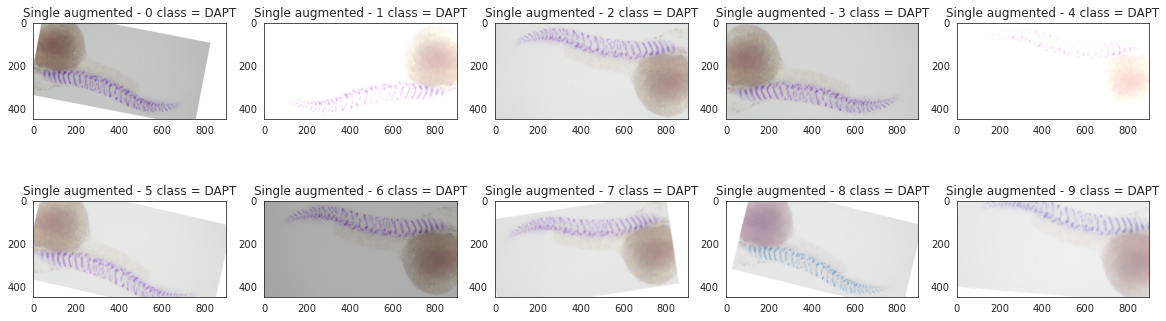

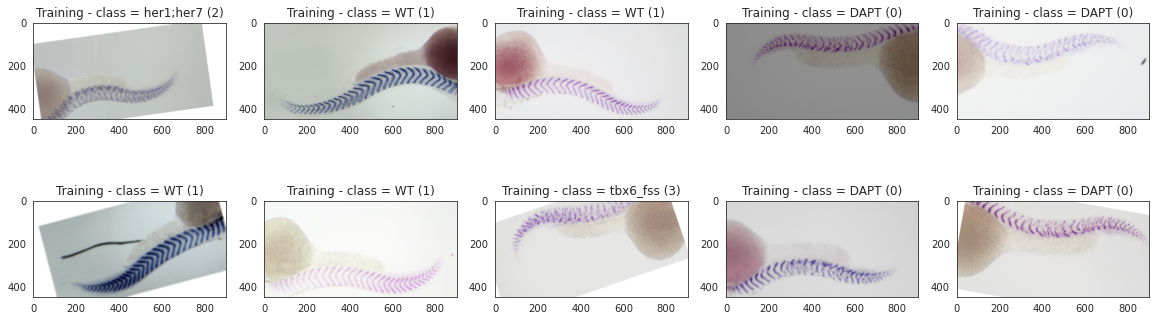

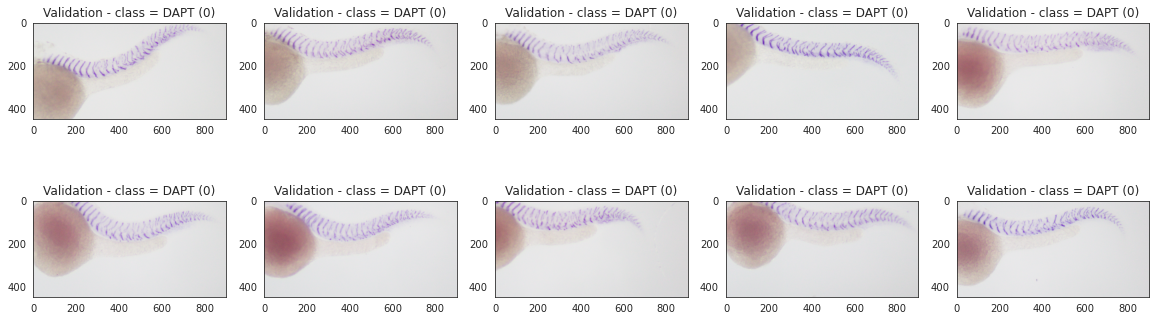

In [3]:
data_train = create_dataset(dataroot/"training",   target_size=target_size, batchsize=16, shuffle=True,  augment=True, grayscale=grayscale)
data_val   = create_dataset(dataroot/"validation", target_size=target_size, batchsize=16, shuffle=False, augment=False, grayscale=grayscale)

print(data_train.class_name_to_id)
print(data_train.class_id_to_name)

# plot some example training and validation images
n=5

plt.figure(figsize=(20,6))
for i in range(2*n):
    _x = data_train.transform(image=data_train.images[0])['image']
    plt.subplot(2, n, i+1)
    plt.imshow(np.clip(_x, 0,1))
    plt.title(f'Single augmented - {i} class = {data_train.class_id_to_name[data_train.labels[0]]}')
     
x,y = next(iter(data_train.data))
plt.figure(figsize=(20,6))
for i, (_x, _y) in enumerate(zip(x[:2*n],y[:2*n])):
    plt.subplot(2,n, i+1)
    plt.imshow(np.clip(_x, 0,1))
    plt.title(f'Training - class = {data_train.class_id_to_name[int(_y)]} ({int(_y)})')

x,y = next(iter(data_val.data))
plt.figure(figsize=(20,6))
for i, (_x, _y) in enumerate(zip(x[:2*n],y[:2*n])):
    plt.subplot(2,n, i+1)
    plt.imshow(np.clip(_x, 0,1))
    plt.title(f'Validation - class = {data_train.class_id_to_name[int(_y)]} ({int(_y)})')


### Building and compiling the model

In [10]:
def build_model(shape):
    inp = tf.keras.Input(shape=shape)

    model_pretrained = tf.keras.applications.MobileNetV2(
        input_shape=shape, include_top=False, weights='imagenet')
    model_pretrained.trainable = False
    features = model_pretrained(inp, training=False)
    features = tf.keras.layers.Conv2D(64, 1, padding="same", activation="relu")(features)

    # attention mask
    # two small pointwise convolutions
    attention = tf.keras.layers.Conv2D(64,3, padding="same", activation="tanh")(features)
    attention = tf.keras.layers.Conv2D(1,3, padding="same", activation="linear")(attention)
    # make sure that it sums to one...
    shape = attention.get_shape().as_list()        
    attention = tf.keras.layers.Flatten()(attention)
    attention = tf.math.softmax(attention)
    attention = tf.keras.layers.Reshape(shape[1:])(attention)
    # multiply by normalized attention 
    x = tf.multiply(features, attention)
    x = tf.math.reduce_sum(x, axis=(1,2)) #attention pooling
    #x = tf.math.reduce_mean(features, axis=(1,2)) #no attention
    model_attention = tf.keras.Model(inp, attention)
    x = tf.keras.layers.Dropout(0.2)(x)
    out = tf.keras.layers.Dense(4,)(x)

    model = tf.keras.Model(inp, out)
    return model, model_attention 

model, model_attention = build_model(target_size+(3,))

learning_rate = 5e-4

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['sparse_categorical_accuracy'])

#preparing the weights for balanced training
counts_mean = np.mean(tuple(data_train.counts.values()))
class_weights = dict((k, counts_mean/v) for k,v in data_train.counts.items())
print(f'class weights: {class_weights}')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00025, verbose = 1)

checkpoint_folder = Path('checkpoints')
checkpoint_folder.mkdir(exist_ok=True, parents=True)

checkpoint_filepath = checkpoint_folder/f"MIL_classifier.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)

class weights: {0: 0.7834645669291339, 1: 0.5653409090909091, 2: 1.7155172413793103, 3: 2.689189189189189}


### Training the model

In [11]:
#data_val = create_dataset(dataroot/'kings', augment=False, shuffle=False, target_size=target_size)

In [12]:
history = model.fit(data_train.data.repeat(4),
                epochs=30,
                validation_data=data_val.data,
                class_weight=class_weights, callbacks=[model_checkpoint_callback])
np.save(checkpoint_folder/f"MIL_lr_{learning_rate:.4f}_epochs_{epochs}.npy",history.history)

Epoch 1/30
100/100 [==============================] - 14s 93ms/step - loss: 0.6583 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.2685 - val_sparse_categorical_accuracy: 0.9250
Epoch 2/30
100/100 [==============================] - 11s 98ms/step - loss: 0.2308 - sparse_categorical_accuracy: 0.9422 - val_loss: 0.1659 - val_sparse_categorical_accuracy: 0.9625
Epoch 3/30
100/100 [==============================] - 11s 93ms/step - loss: 0.1628 - sparse_categorical_accuracy: 0.9579 - val_loss: 0.2746 - val_sparse_categorical_accuracy: 0.9500
Epoch 4/30
100/100 [==============================] - 11s 92ms/step - loss: 0.1150 - sparse_categorical_accuracy: 0.9673 - val_loss: 0.0743 - val_sparse_categorical_accuracy: 0.9875
Epoch 5/30
100/100 [==============================] - 11s 91ms/step - loss: 0.1429 - sparse_categorical_accuracy: 0.9692 - val_loss: 0.1925 - val_sparse_categorical_accuracy: 0.9375
Epoch 6/30
100/100 [==============================] - 11s 92ms/step - loss: 0.1445 - spars

### Loading the best-epoch weights of the trained model

In [ ]:
model.load_weights(checkpoint_filepath)

### Loading history and plot learning curves

In [ ]:
history=np.load(checkpoint_folder/f"MIL_lr_{learning_rate:.4f}_epochs_{epochs}.npy",allow_pickle='TRUE').item()

acc = history[f'sparse_categorical_accuracy']
val_acc = history[f'val_sparse_categorical_accuracy']

loss = history[f'loss']
val_loss = history[f'val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss');


### Calculate confusion matrix

In [ ]:
y_true = np.array(data_val.labels)
y_pred = np.argmax(model.predict(data_val.data), -1)

def calculate_confusion_matrix(y_true, y_pred):
    classes = tuple(data_val.class_id_to_name[i] for i in range(4))
    matrix = metrics.confusion_matrix(y_true, y_pred) #rows - true, columns - predicted
    matrix = matrix/np.sum(matrix, axis=-1, keepdims=True)
    
    df_cm = pd.DataFrame(matrix, index=classes, columns=classes)
    # plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='1.3f')# font size
    plt.ylabel("True class")
    plt.xlabel("Predicted class") 
    plt.show()
    accuracy = np.sum(np.diag(matrix))/np.sum(matrix)
    print(f'Accuracy: {accuracy:.4f}') 
    return accuracy

accuracy = calculate_confusion_matrix(y_true, y_pred)

# Apply the model to new images from a different microscope (`kings` subset)

Put the `kings` images (in bmp format) in the subfolder `data/kings`, resulting in 

```
data
├── fish_part_labels
│   ├── DAPT
│   ├── her1;her7
│   ├── tbx6_fss
│   └── WT
├── kings
│   ├── DAPT
│   └── WT
├── training
│   ├── DAPT
│   ├── her1;her7
│   ├── tbx6_fss
│   └── WT
└── validation
    ├── DAPT
    ├── her1;her7
    ├── tbx6_fss
    └── WT
```

In [ ]:
data_new = create_dataset(dataroot/'kings', augment=False, shuffle=False, target_size=target_size, grayscale=grayscale)

x,y = next(iter(data_new.data))
plt.figure(figsize=(20,5))
for i, (_x, _y) in enumerate(zip(x[:2*n],y[:2*n])):
    plt.subplot(2,n, i+1)
    plt.imshow(np.clip(_x, 0,1))
    plt.title(f'New image - class = {data_train.class_id_to_name[int(_y)]} ({int(_y)})')


In [ ]:
y_true = np.array(tuple(data_new.class_id_to_name[c] for c in data_new.labels))
y_prob = tf.math.softmax(model.predict(data_new.data))
y_pred = np.array(tuple(data_train.class_id_to_name[c] for c in np.argmax(y_prob, -1)))
y_prob = np.max(y_prob, axis=-1)

accuracy = np.mean(y_true==y_pred)
print(f'Accuracy: {accuracy:.5f}')


In [ ]:
for i, (x, fname, y1, y2, prob) in enumerate(zip(data_new.images, data_new.filenames, y_true, y_pred, y_prob)):
    if i%4==0:
        plt.figure(figsize=(20,4))
    ax = plt.subplot(1,4,i%4+1)
    ax.imshow(x)
    correct = y1==y2
    ax.set_title(f'{"correct" if correct else "wrong"} ({y1} -> {y2} with prob {prob:.2f})', fontsize=10)
    ax.title.set_color('green' if correct else 'red')
    ax.axis('off')

### Show a few examples of the attention mask

In [ ]:
x, y = next(iter(data_val.data))

pred = np.argmax(model.predict(x), axis=-1)
att = model_attention.predict(x)
n_plot= 4
plt.figure(figsize=(20,10))
for i,(_x,_y,_p, _a) in enumerate(zip(x[:n_plot],y[:n_plot], pred[:n_plot], att[:n_plot])):
    plt.subplot(2,n_plot,i+1)
    plt.imshow(_x)
    plt.title(f"True: {data_val.class_id_to_name[int(_y)]}")    
    plt.subplot(2,n_plot,n_plot+i+1)

    plt.imshow(_x[...,0])    
    plt.imshow(resize(_a,_x.shape[:2])[:,:,0], alpha=.6, cmap = 'magma')
    plt.title(f"Pred: {data_val.class_id_to_name[int(_p)]}")

### Calculating attention for all images and saving validation set images with attention overlayed

In [ ]:
data_test = create_dataset(dataroot/"validation", target_size=target_size, batchsize=1, shuffle=False, augment=False)

outfolder = Path('MIL_results')
folder_parts = dataroot/"fish_part_labels"

#saving of the predicted images
out_folders = dict((k, outfolder/v) for k,v in data_test.class_id_to_name.items())
for k,folder in out_folders.items():
    folder.mkdir(exist_ok =True, parents=True)        

for i, ((x,y),filename) in tqdm(enumerate(zip(data_test.data, data_test.filenames)), total=len(data_test.data)):
    y_pred = np.argmax(model.predict(x,verbose=False), axis=-1)
    y_true = int(y[0])
    att = model_attention.predict(x,verbose=False)[0,:,:,0]
    
    fname_parts = Path(*Path(filename).parts[-2:])
    parts = tifffile.imread(folder_parts/f'{fname_parts}.tiff')
    resized_parts = resize(parts, (450,900), order=0) #everything is streched to the shape of the loaded image
    parts_array_binarized = np.where(resized_parts > 0, 0, 1)

    if i<10:
        fig = plt.figure()
        plt.imshow(x[0])   
        plt.imshow(resize(att,x[0].shape[:2]), alpha=0.4, cmap = 'magma')
        plt.imshow(parts_array_binarized, alpha = 0.1)
        plt.box(False)
        plt.axis('off')
        
    plt.savefig(out_folders[y_true]/Path(filename).name, dpi = fig.dpi, transparent=True)


### Calculating the per-class- and per-fish-part attention for images from the validation set

In [ ]:
def calculate_attention(image, mask, index, normalization = False):
    if(image.shape != mask.shape):
        raise Exception('Image and Mask should have the same shape', image.shape, mask.shape)

    index_mask = (mask==index)
    attention = np.sum(index_mask*image)
    if normalization:
        attention = attention / (np.sum(index_mask)+1e-10)
    return attention


Attention = np.empty((4, 6, 20)) #4 rows are the classes, 5 colums are different zebrafish parts
#indices for zebrafish parts: (in the array as well the values on the zebrafish part paintings)
#0 - background
#1 - head
#2 - trunk
#3 - tail 
#4 - yolk
#5 - yolk extension

class_counter = np.zeros(4) #keeping track of how many images from a certain class there were so far
normalization = 1


for i, ((x,y),filename) in tqdm(enumerate(zip(data_test.data, data_test.filenames)), total=len(data_test.data)):
    y_pred = np.argmax(model.predict(x,verbose=False), axis=-1)
    y_true = int(y[0])
    att = model_attention.predict(x,verbose=False)[0,:,:,0]
    resized_att = resize(att, x[0].shape[:2])
    #resizing changes values so we scale attention back to 1
    resized_att = resized_att/np.sum(resized_att)

    
    fname_parts = Path(*Path(filename).parts[-2:])
    parts = tifffile.imread(folder_parts/f'{fname_parts}.tiff')
    resized_parts = resize(parts, (450,900), order=0) #everything is streched to the shape of the loaded image
    parts_array_binarized = np.where(resized_parts > 0, 0, 1)

    for p in range(0,6):
        Attention[int(y_true), p, int(class_counter[int(y_true)])] = calculate_attention(resized_att, resized_parts, p, normalization)                
    class_counter[int(y_true)] = class_counter[int(y_true)] + 1

### Ploting attention analysis results

In [ ]:
#plotting per class
for i in range(4):
    df = pd.DataFrame({'BKGD': Attention[i, 0, :], 'Head': Attention[i, 1, :], 'Trunk': Attention[i, 2, :], 'Tail': Attention[i, 3, :], 'Yolk': Attention[i, 4, :], 'Y.E.': Attention[i, 5, :]})
    
    plt.figure()
    ax = sns.violinplot(data = df.iloc[:, 0:6]*100, color= np.array([185, 208, 229])/255, scale='width', bw = 'scott') #we scale Y axis so that it represents percentages
    #ax.set(ylabel="Attention [%]")
    #plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6])
    plt.title(data_val.class_id_to_name[i])
    plt.ylim([-0.0001, 0.01])

parts = ['BKGD', 'Head', 'Trunk', 'Tail', 'Yolk', 'Yolk Extension']

#plotting per fish part
for i in range(6):
    df = pd.DataFrame({'WT': Attention[1, i, :], 'tbx6': Attention[3, i, :], 'DAPT': Attention[0, i, :], 'her1;her7': Attention[2, i, :]})
    plt.figure()
    ax = sns.violinplot(data = df.iloc[:, 0:6]*100, color= np.array([185, 208, 229])/255, scale='width', bw = 'scott') #we scale Y axis so that it represents percentages
    #ax.set(ylabel="Attention [%]")
    #plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6])
    plt.title(parts[i])
    plt.ylim([-0.0001, 0.01])


### Calculating statistics for attention distribution among different classes

In [ ]:
#calculating two-sided p tests for differences in attention

#significance for tail being more important in WT than her1;her7
p = scipy.stats.ttest_ind(Attention[1,3,:], Attention[2,3,:])
print(p.pvalue)
#significance for tail being more important in WT than tbx6
p = scipy.stats.ttest_ind(Attention[1,3,:], Attention[3,3,:])
print(p.pvalue)
#significance for tail being more important in DAPT than tbx6
p = scipy.stats.ttest_ind(Attention[0,3,:], Attention[3,3,:])
print(p.pvalue)

#significance for yolk extension being more important in tbx6 than in the her1;her7
p = scipy.stats.ttest_ind(Attention[3,5,:], Attention[2,5,:])
print(p.pvalue)

### Analyzing the size of the first parts of different classes

In [ ]:
#calculating the parts of the images that are occupied by the fish

fish_occupancy = np.zeros((4,6,20))
#0 - background
#1 - head
#2 - trunk
#3 - tail 
#4 - yolk
#5 - yolk extension

#class order
#0 - DAPT 
#1 - WT
#2 - her1;her7
#3 - tbx6_fss

for cl_i, cl in data_test.class_id_to_name.items():
    for i,f in tqdm(enumerate((folder_parts/cl).glob('*.tiff'))):
        parts = tifffile.imread(f)
        counts = np.bincount(parts.flatten())    
        fish_occupancy[cl_i, :, i] = counts
        fish_occupancy[cl_i, :, i] = fish_occupancy[cl_i, :, i]/parts.size

        
df_fish_occupancy = pd.DataFrame(np.transpose(np.mean(fish_occupancy, axis = 2)), columns = ['DAPT', 'WT', 'her1;her7', 'tbx6_fss'], index = ['BKGD', 'Head', 'Trunk', 'Tail', 'Yolk', 'Y.E.'])
df_fish_occupancy = df_fish_occupancy[['WT', 'tbx6_fss', 'DAPT', 'her1;her7']]
df_fish_occupancy = df_fish_occupancy.rename(columns = {'tbx6_fss':'tbx6'})
#print(df_fish_occupancy['DAPT'])
fig, ax = plt.subplots(1,1,figsize=(10,5))
df_fish_occupancy.plot.bar(rot=0, ax=ax)